In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
import time
import multiprocessing
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df_shanghai = pd.read_csv('sh_ershou_clean.csv', index_col = 0)
df_hangzhou = pd.read_csv('hz_ershou_clean.csv', index_col = 0)

In [3]:
print('df_shanghai.shape:{}'.format(df_shanghai.shape))
print('df_hangzhou.shape:{}'.format(df_hangzhou.shape))

df_shanghai.shape:(14780, 7)
df_hangzhou.shape:(35942, 7)


In [6]:
df_shanghai['year'] = df_shanghai['info'].str.extract('([\d]+)年').astype('float')
df_shanghai['age'] = 2022-df_shanghai.year
# df_hangzhou['year'] = df_hangzhou['info'].str.extract('([\d]+)年').astype('float')
# 杭州数据没有建房年份

In [19]:
df_shanghai.describe()

,total_price,unit_price,area,year,age
count,14780.000000,14780.000000,14780.000000,13498.000000,13498.000000
mean,514.321616,60010.600474,85.362117,1999.543932,22.456068
std,520.297698,28833.133598,58.490598,11.070863,11.070863
min,36.000000,9743.000000,8.680000,1911.000000,2.000000
25%,253.000000,38246.500000,51.907500,1994.000000,14.000000
50%,385.000000,58976.500000,72.880000,1999.000000,23.000000
75%,600.000000,77363.750000,101.985000,2008.000000,28.000000
max,17800.000000,451777.000000,1547.730000,2020.000000,111.000000


对上海数据进行聚类

In [56]:
# 对数值型数据进行标准化
t= preprocessing.StandardScaler().fit(df_shanghai[df_shanghai.describe().columns])
df_shanghai_processed = pd.DataFrame(t.transform(df_shanghai[df_shanghai.describe().columns]))
df_shanghai_processed.columns = df_shanghai.describe().columns

In [57]:
# 类别型变量进行labelenconding
df_shanghai_processed['location1'] = df_shanghai.location1
le = preprocessing.LabelEncoder()
df_shanghai_processed['location1'] = le.fit_transform(df_shanghai_processed['location1'])

In [61]:
# 将label_encoding的映射关系记录下来
def pkl_save(filename, file):
    #将file保存到filename中
    output = open(filename, 'wb')
    pickle.dump(file, output)
    output.close()

pkl_save('shanghai_location1_labelencoding.pkl', le)

In [62]:
# 缺失值填充
df_shanghai_processed.year.fillna(df_shanghai_processed.year.mean(), inplace = True)
df_shanghai_processed.age.fillna(df_shanghai_processed.age.mean(), inplace = True)

In [63]:
from kmodes.kprototypes import KPrototypes

In [97]:
cate_index = [5] # 为类别型变量在columns中的索引
def TrainCluster(df, model_name=None, start_k=2, end_k=10):
    print('training cluster')
    K = []
    SSE = []
    silhouette_all=[]
    models = [] #保存每次的模型
    for i in range(start_k, end_k):
        start = time.perf_counter ()
        kproto_model = KPrototypes(n_clusters=i, n_jobs=multiprocessing.cpu_count())
        kproto_model.fit(df_shanghai_processed,categorical=cate_index)
        SSE.append(kproto_model.cost_)  # 保存每一个k值的SSE值
        K.append(i)
        print('{}-prototypes SSE loss = {}'.format(i, kproto_model.cost_))
        models.append(kproto_model) #保存每个k值对应的模型
        end = time.perf_counter ()
        print('Running time: %s Seconds'%(end-start))

    return(K,SSE,models)

In [99]:
K, SSE, models = TrainCluster(df = df_shanghai_processed)

training cluster
2-prototypes SSE loss = 58809.79071753508
Running time: 64.79066440000042 Seconds
3-prototypes SSE loss = 45201.28197321835
Running time: 65.0152863000003 Seconds
4-prototypes SSE loss = 38331.770363498814
Running time: 144.35168930000054 Seconds
5-prototypes SSE loss = 33471.205293080806
Running time: 90.9471966000001 Seconds
6-prototypes SSE loss = 30541.7419155361
Running time: 141.77380129999983 Seconds
7-prototypes SSE loss = 28114.384722203155
Running time: 193.68540699999994 Seconds
8-prototypes SSE loss = 26252.713164768087
Running time: 234.6029128 Seconds
9-prototypes SSE loss = 24199.270131151
Running time: 169.6960337999999 Seconds


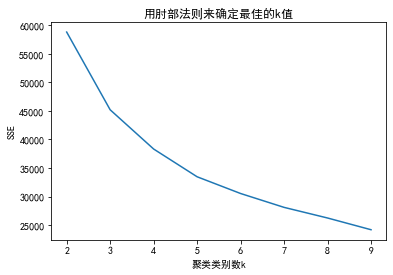

In [111]:
# 决定选择5
plt.plot(K, SSE)
plt.xlabel('聚类类别数k')
plt.ylabel('SSE')
plt.xticks(K)
plt.title('用肘部法则来确定最佳的k值')
plt.show()

In [203]:
#确定了最佳的k值后：5
best_model = models[K.index(5)]

In [204]:
df_shanghai['labels_'] = best_model.labels_

In [205]:
center = pd.DataFrame(best_model.cluster_centroids_ )
center.columns = df_shanghai_processed.columns

In [206]:
# 添加原始值
for col in center.columns[:-1]:
    col_new = col+'_raw'
    mean = df_shanghai[col].mean()
    std = df_shanghai[col].std()
    center[col_new] = center[col]*std+mean
    print(col_new)

total_price_raw
unit_price_raw
area_raw
year_raw
age_raw


In [210]:
center

,total_price,unit_price,area,year,age,location1,total_price_raw,unit_price_raw,area_raw,year_raw,age_raw
0,-0.196831,0.857112,-0.633931,-1.509358,1.509358,70.0,411.910757,84723.818809,48.283100,1982.834041,39.165959
1,1.028339,0.943943,0.683080,0.283296,-0.283296,55.0,1049.363989,87227.448686,125.315853,2002.680261,19.319739
2,-0.360165,-0.776708,0.068983,0.943399,-0.943399,148.0,326.928768,37615.670691,89.396985,2009.988176,12.011824
3,5.232979,1.179193,5.146247,0.660238,-0.660238,162.0,3237.028695,94010.433144,386.369159,2006.853337,15.146663
4,-0.321592,-0.224998,-0.321260,-0.309066,0.309066,11.0,346.998185,53523.203484,66.571404,1996.122307,25.877693


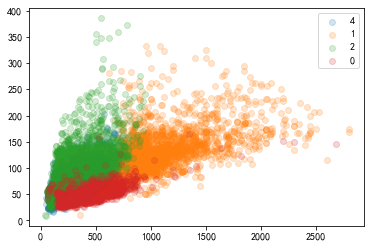

In [209]:
# 绘制散点图
colors1 = '#00CED1' #点的颜色
colors2 = '#DC143C'

col1 = 'total_price'
col2 = 'area'

for label in df_shanghai.labels_.unique():
    if label != 3:
        x = df_shanghai.loc[df_shanghai.labels_ == label, col1]
        y = df_shanghai.loc[df_shanghai.labels_ == label, col2]
        plt.scatter(x, y, label = str(label), alpha = 0.2)

plt.legend()